### Combined Cycle Power Plant Data Set 

In [373]:
# Imports 
import pandas as pd 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression 


from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from statsmodels.stats.outliers_influence import OLSInfluence


#### Data Exploration 

In [151]:
# Specify the path to the excel file 
cpp_data = Path('Folds5x2_pp.xlsx')

# Read the Excel file into a DataFrame
# If the file has no header, you can provide column names using the 'names' parameter
cpp_data = pd.read_excel(cpp_data, decimal='.',)

# Review the first and last five rows of the DataFrame
print(cpp_data)
print("There are 9568 rows and 4 columns")
print("The rows are features like and the columns are data collected for each feature")

         AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9568 rows x 5 columns]
There are 9568 rows and 4 columns
The rows are features like and the columns are data collected for each feature


### Pairwise Scatterplot 

Text(0.5, 1.02, 'Scatter Plots of All Variables')

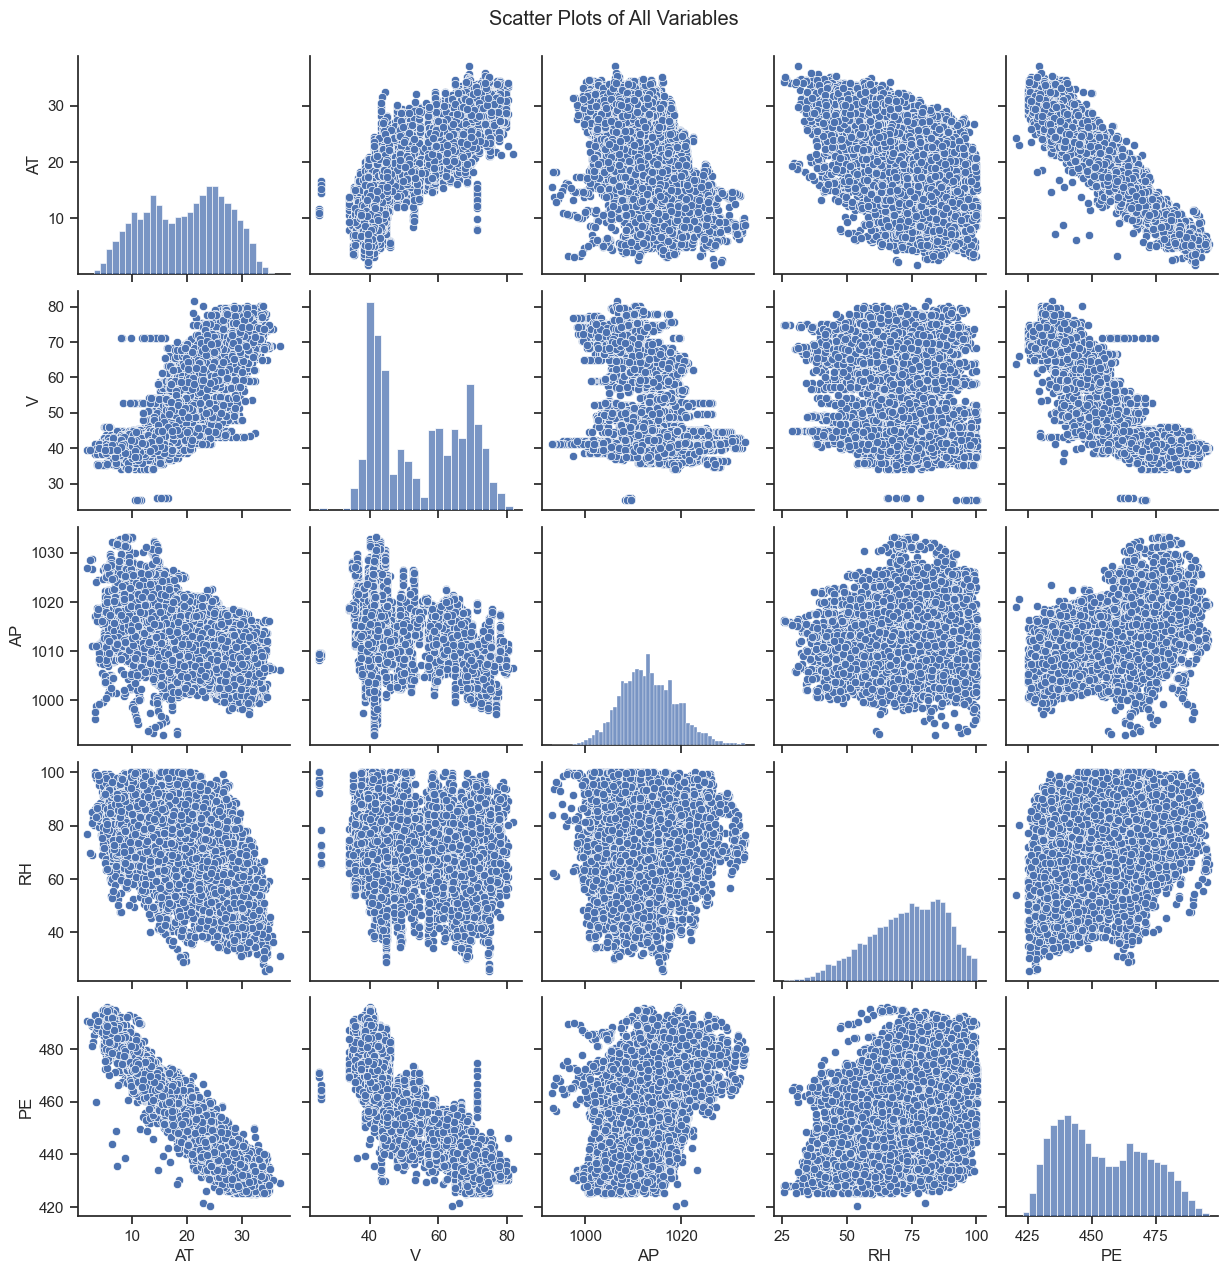

In [152]:
sns.set_theme(style = 'ticks')

import warnings
warnings.filterwarnings('ignore')


a = sns.pairplot(data=cpp_data, palette='deep')
a.fig.suptitle("Scatter Plots of All Variables", y=1.02)

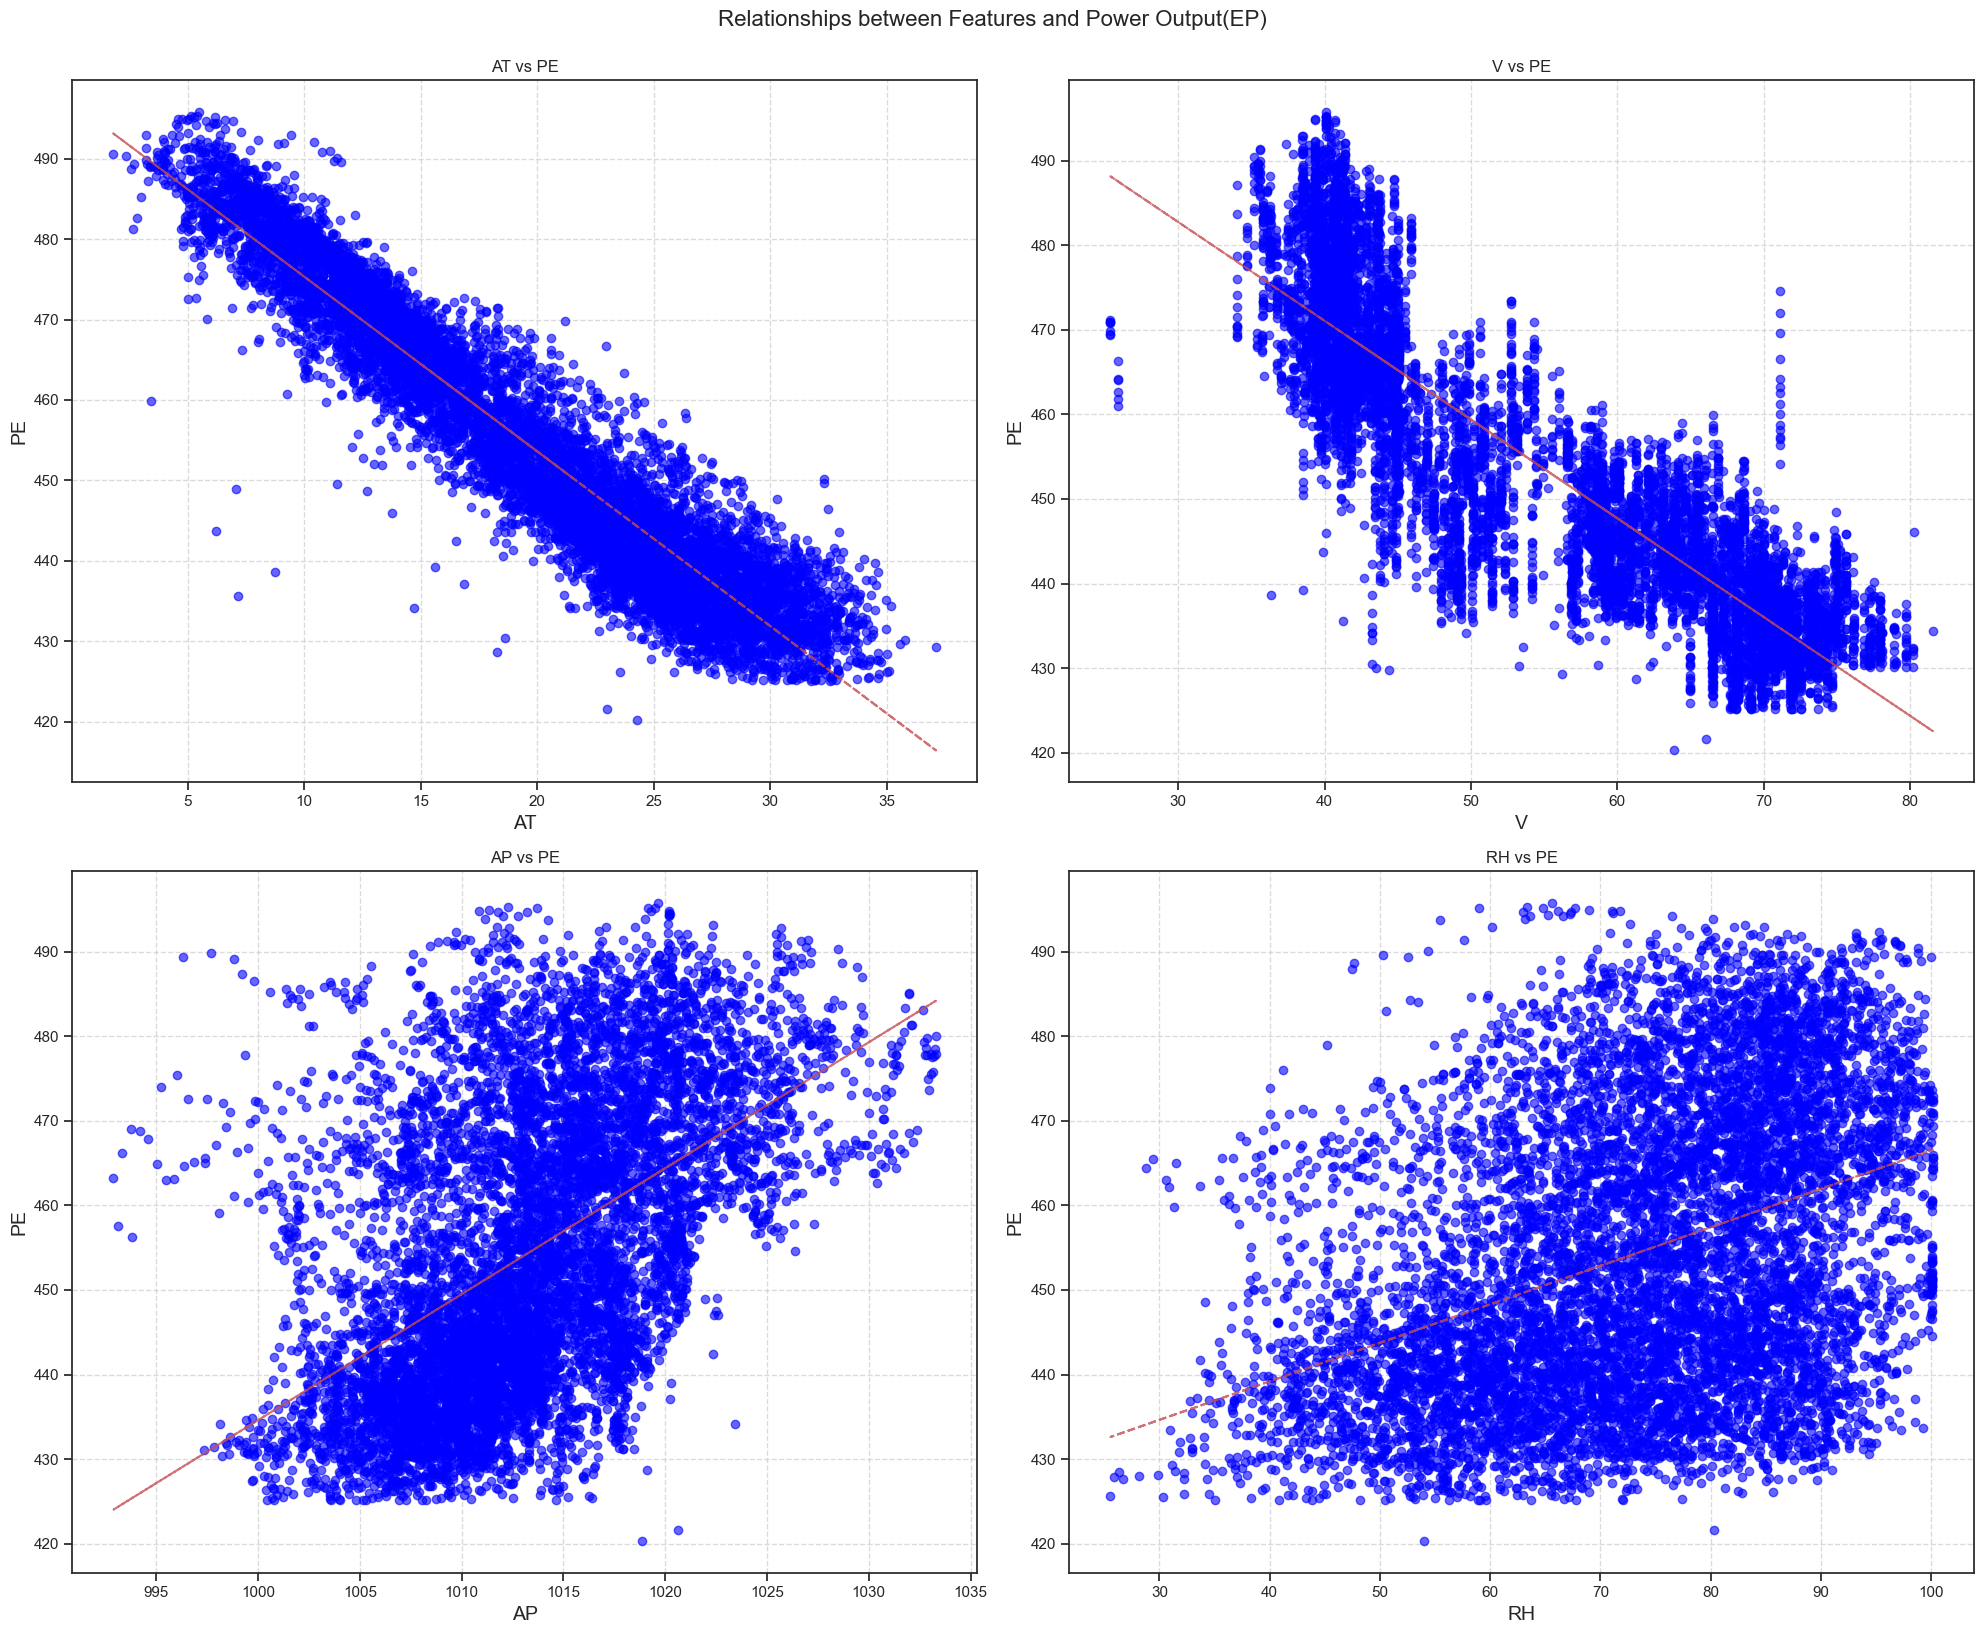

In [155]:
# Note: The feature of the Dataset are hourly ambient variables such as: Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH), and Exhaust Vacuum (V). 
# These are used to predict the dependent variable which is energy output of the power plant (PE)
# List of independent variables
features = ['AT','V', 'AP', 'RH']

# Dependent variable
dependent_variable = 'PE'

# Create a 2x3 grid of subplots (6 plots for 6 features)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# Add color palette for consistency 
colors = sns.color_palette('viridis', n_colors=len(features))

# Create scatterplots for each feature vs the dependent variable
for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(cpp_data[feature], cpp_data[dependent_variable], alpha=0.6, c='blue')
    ax.set_xlabel(feature, fontsize=14)
    ax.set_ylabel(dependent_variable, fontsize=14)
    ax.set_title(f'{feature} vs {dependent_variable}')

    # Add grid for better readability 
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add a trend line
    z = np.polyfit(cpp_data[feature], cpp_data[dependent_variable], 1)
    p = np.poly1d(z)
    ax.plot(cpp_data[feature], p(cpp_data[feature]), "r--", alpha=0.8)

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Relationships between Features and Power Output(EP)', fontsize=16, y=1.02)
plt.show()


### Summary of Pairwise Plots 
From the plots above, we can Ambient Temperature (AT) vs Energy Output (PE) and Exhaust Vacuum (V) vs Energy Output (PE) have the strongest correlation out of all four graphs. For every 5 unit increase in Ambient Temperature there is approximately a 10 unit decrease in Energy Ouput, this would also indicate that the two variables might have an inverse relationship. 

### Mean, Median, and Mode

In [156]:
cpp_data.describe()

AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000

In [157]:
cpp_data.mode()

AT      V       AP      RH     PE
0  25.21  41.17  1013.88  100.09  468.8
1    NaN  70.32      NaN     NaN    NaN

In [158]:
# Prepare the data
data = [
    ["Ambient Temp", 19.651231, 20.345, 25.21],
    ["Exhaust Vacuum", 54.305804, 52.080, 41.17],
    ["Ambient Pressure", 1013.259078, 1012.940, 1013.88], 
    ["Relative Humidity", 73.308978, 74.975, 100.09],
    ["Energy Output", 54.365009, 451.550, 468.8]
]

# Create the table
table = tabulate(data, headers=["Variables", "Mean", "Median", "Mode"], tablefmt="fancy_grid")

# Print the table
print(table)
print(f"There are two modes that exist for Exhaust Vacuum: 41.17 and 70.32")

╒═══════════════════╤═══════════╤══════════╤═════════╕
│ Variables         │      Mean │   Median │    Mode │
╞═══════════════════╪═══════════╪══════════╪═════════╡
│ Ambient Temp      │   19.6512 │   20.345 │   25.21 │
├───────────────────┼───────────┼──────────┼─────────┤
│ Exhaust Vacuum    │   54.3058 │   52.08  │   41.17 │
├───────────────────┼───────────┼──────────┼─────────┤
│ Ambient Pressure  │ 1013.26   │ 1012.94  │ 1013.88 │
├───────────────────┼───────────┼──────────┼─────────┤
│ Relative Humidity │   73.309  │   74.975 │  100.09 │
├───────────────────┼───────────┼──────────┼─────────┤
│ Energy Output     │   54.365  │  451.55  │  468.8  │
╘═══════════════════╧═══════════╧══════════╧═════════╛
There are two modes that exist for Exhaust Vacuum: 41.17 and 70.32


### Simple Linear Regression Model 

#### Train_test_split

In [159]:
# For each predictor, fit a simple linear regression model to predict a response 
X = cpp_data[['AT', 'V', 'AP', 'RH']]
y = cpp_data['PE']
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7654, 4)
X_test shape: (1914, 4)
y_train shape: (7654,)
y_test shape: (1914,)


#### Fit a Linear Regression Model using the X_train and y_train data

In [160]:
# Instantiate the Linear Regression model 
model = LinearRegression(fit_intercept=True, copy_X=True, positive=False)

# Fit the model using the training data 
model.fit(X_train, y_train)

# Validate the model using the test data 
print(f"Training Data Score: {model.score(X_train, y_train)}")
print(f"Testing Data Score: {model.score(X_test, y_test)}")

Training Data Score: 0.928331545565795
Testing Data Score: 0.9301046431962188


In [161]:
# Make a prediction using the testing data 
y_pred = model.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

Prediction  Actual
2513  455.680208  455.27
9411  438.732122  436.31
8745  434.164440  440.68
9085  438.769546  434.40
4950  479.888329  482.06
...          ...     ...
7204  434.222345  430.24
1599  475.443004  473.20
5697  482.168174  479.53
350   435.415244  435.76
6210  458.761506  457.10

[1914 rows x 2 columns]

### Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) Plots 

#### Root Mean Squared Error (RMSE)
- Measures the square root of the average squared differences between predicted and actual values
- RMSE penalizes large errors more than MAE due to squaring the errors. Thus, lower values indicate better performance

#### Mean Absolute Error (MAE)
- Measures the average magnitude of errors in a set of predictions, without considering their direction. 
- Lower values indicate better performance. 


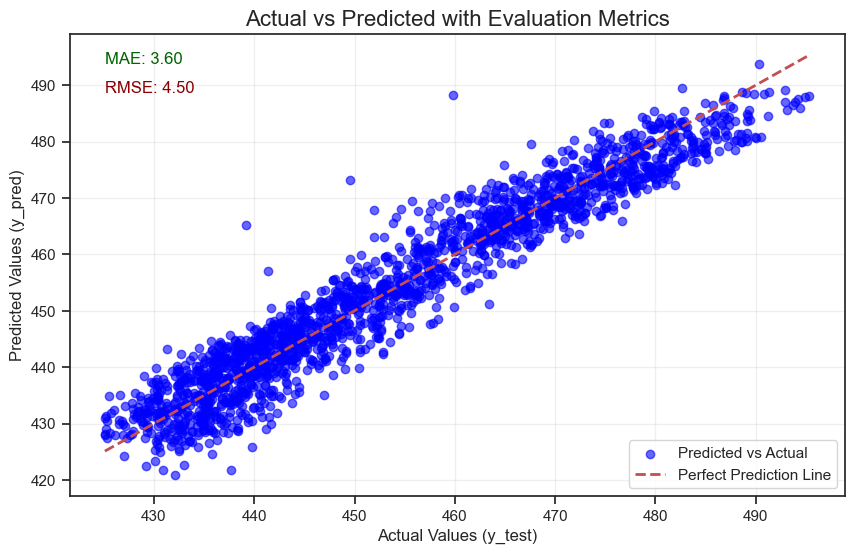

In [162]:
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')

# Add MAE and RMSE as text annotations
plt.text(min(y_test), max(y_pred), f'MAE: {mae:.2f}', fontsize=12, color='darkgreen')
plt.text(min(y_test), max(y_pred) - 5, f'RMSE: {rmse:.2f}', fontsize=12, color='darkred')

# Add labels and title
plt.title('Actual vs Predicted with Evaluation Metrics', fontsize=16)
plt.xlabel('Actual Values (y_test)', fontsize=12)
plt.ylabel('Predicted Values (y_pred)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


### C. In the model is there a statistically significant association between the predictor and the response. Make sure to create plots to explain and back up your statements. Are there also any outliers you would like to remove from the data for each of the regression tasks?

In [163]:
# Add an intercept to your predictors
X = sm.add_constant(X)  

# Fit an Ordinary Least Squares (OLS) regression model
model = sm.OLS(y_train, X_train).fit()

# Print summary of results
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:                     PE   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.542e+07
Date:                Mon, 10 Feb 2025   Prob (F-statistic):                        0.00
Time:                        22:07:44   Log-Likelihood:                         -23276.
No. Observations:                7654   AIC:                                  4.656e+04
Df Residuals:                    7650   BIC:                                  4.659e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [164]:
# Extract coefficients and store them in a dictionary
coefficients = model.params.to_dict()

# Save the coefficients for later use
print("Estimated Coefficients:")
print(coefficients)

Estimated Coefficients:
{'AT': -1.690284922895354, 'V': -0.2681551376931687, 'AP': 0.5028805021537607, 'RH': -0.10095480700463969}


In [167]:
X_train.head()

AT      V       AP     RH
5487  21.92  49.02  1009.29  88.56
3522  11.09  40.43  1025.47  74.97
6916   8.49  39.61  1021.05  87.74
7544  11.43  44.78  1013.43  82.45
7600  17.28  39.99  1007.09  74.25

#### Feature vs. Energy Output Plots and Outliers Plots
### Identifying Outliers 
- In order to identify outliers within our data we can calculate the zscore to find how many standard deviations a data point is from the mean. 
- However, for some of the features, I didn't see significant outliers so I decided to calculate Cook's Distance. Cook's Distance in some cases can be a more beneficial way to determine outliers specifically in a regression model. 

In [223]:
from texttable import Texttable

# Create a Texttable object
table = Texttable()

# Set column widths (adjust as needed)
table.set_cols_width([10, 50])

# Add header and rows
table.add_rows([
    ["Method", "Best For"],
    ["Z-Scores", "Univariate data or simple outlier detection."],
    ["Cook's Distance", "Regression models with potential influential points."]
])

# Print the table
print(table.draw())


+------------+----------------------------------------------------+
|   Method   |                      Best For                      |
+============+====================================================+
| Z-Scores   | Univariate data or simple outlier detection.       |
+------------+----------------------------------------------------+
| Cook's     | Regression models with potential influential       |
| Distance   | points.                                            |
+------------+----------------------------------------------------+


## Ambient Temperature Plots

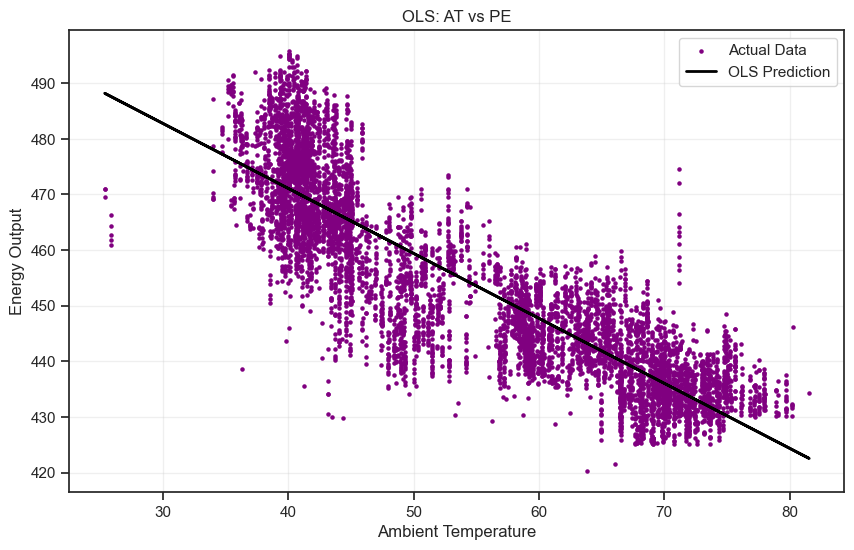

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.370e+04
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:12:17   Log-Likelihood:                -27182.
No. Observations:                7654   AIC:                         5.437e+04
Df Residuals:                    7652   BIC:                         5.438e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        517.8163      0.423   1224.562      0.0

In [305]:
# Initialize an empty list to store coefficients
model_parameters_list = []

# Select one feature from X_train (e.g., the first feature = AT)
feature_index = 0  # Change this to 1, 2, or 3 for other features
X_train_single0 = X_train.iloc[:, feature_index]  # Extract the selected feature

# Add a constant term to the feature (required for statsmodels OLS)
X_train_single_const0 = sm.add_constant(X_train_single)

# Fit a new model using only this feature
model_single = sm.OLS(y_train, X_train_single_const).fit()

# Extract the coefficient and append it to the list 
model_params = model_single.params[-1]
model_parameters_list.append(model_params.tolist())

# Make predictions using the single-feature model
y_pred_single = model_single.predict(X_train_single_const)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train_single, y_train, s=5, color='purple', label='Actual Data')
plt.plot(X_train_single, y_pred_single, color='black', linewidth=2, label='OLS Prediction')

# Add labels and title
plt.xlabel('Ambient Temperature')
plt.ylabel('Energy Output')
plt.title('OLS: AT vs PE')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print the model summary
print(model_single.summary())
# print(f"Coefficients: {coefficients}")
print(model_parameters_list)

Cook's Distance: [2.16498591e-04 5.56399738e-04 7.85459066e-05 ... 1.23137183e-04
 9.51931540e-06 6.24264032e-06]


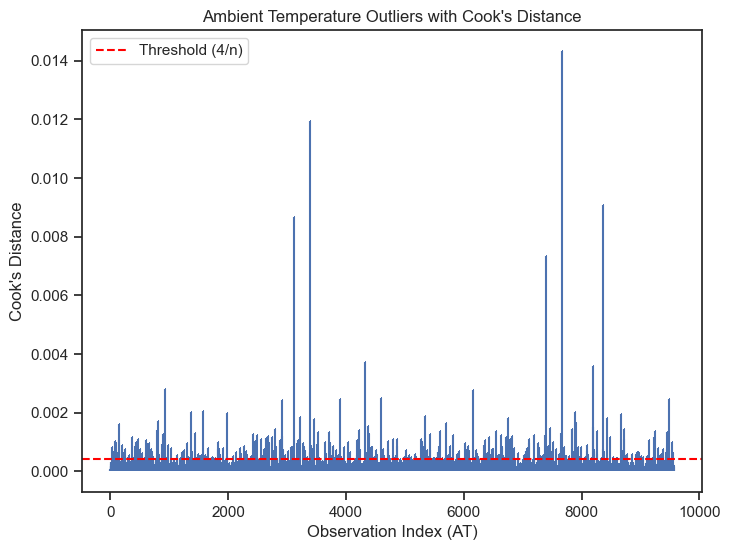

In [288]:
X_feature = sm.add_constant(X[['AT']])
model = sm.OLS(y, X_feature).fit()

influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

print("Cook's Distance:", cooks_distance)

# Plot Cook's distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.axhline(4 / len(cooks_d), color='red', linestyle='--', label='Threshold (4/n)')
plt.title("Ambient Temperature Outliers with Cook's Distance")
plt.xlabel("Observation Index (AT)")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

# Identify influential points
influential_points = np.where(cooks_d > (4 / len(cooks_d)))[0]
# print(f"Influential Points: {influential_points}")

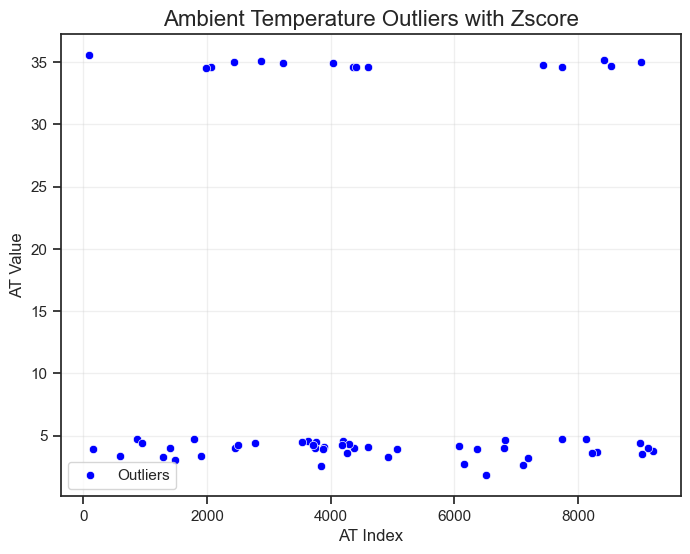

In [277]:
# Calculate Z-scores
z_scores = stats.zscore(X_train_single0)

# Identify outliers (e.g., Z-score > 3 or < -3)
# This is a common threshold for identifying outliers. We want outliers that are 3 or more standard deviations away from the mean.
# In this specific case, changed to 2 STD. because no outliers were detected with 3
outliers = np.abs(z_scores) > 2

# Create scatter plot with outliers highlighted
plt.figure(figsize=(8, 6))
# sns.scatterplot(x=X_train_single.index, y=X_train_single, color='blue', label='Data Points')
sns.scatterplot(x=X_train_single0.index[outliers], y=X_train_single0[outliers], color='blue', label='Outliers')

# Add labels and title
plt.xlabel('AT Index', fontsize=12)
plt.ylabel('AT Value', fontsize=12)
plt.title('Ambient Temperature Outliers with Zscore', fontsize=16)

# Show grid and legend
plt.grid(alpha=0.3)
plt.legend()
plt.show()


## Exhaust Vacuum Plot 

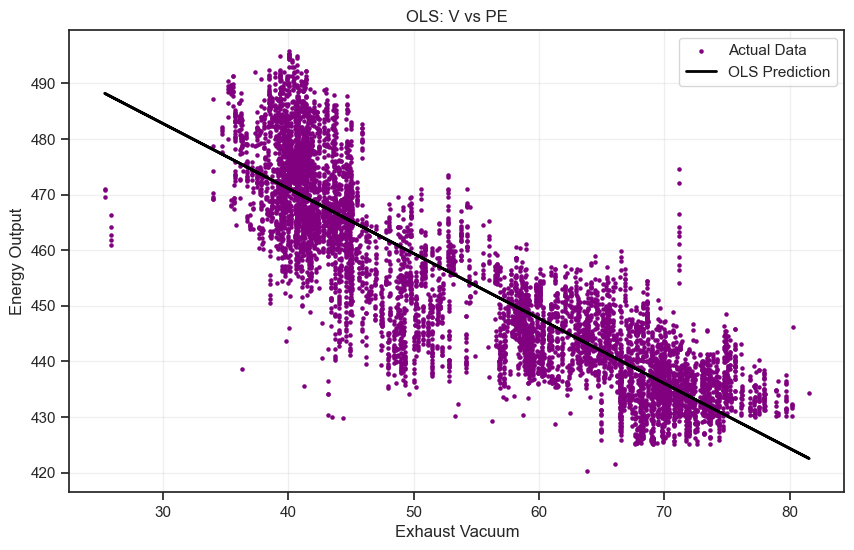

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.370e+04
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:13:31   Log-Likelihood:                -27182.
No. Observations:                7654   AIC:                         5.437e+04
Df Residuals:                    7652   BIC:                         5.438e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        517.8163      0.423   1224.562      0.0

In [306]:
# Select one feature from X_train (e.g., the second feature = V)
feature_index = 1  # Change this to 1, 2, or 3 for other features
X_train_single1 = X_train.iloc[:, feature_index]  # Extract the selected feature

# Add a constant term to the feature (required for statsmodels OLS)
X_train_single_const1 = sm.add_constant(X_train_single1)

# Fit a new model using only this feature
model_single = sm.OLS(y_train, X_train_single_const1).fit()

# Extract the coefficient and append it to the list 
model_params = model_single.params[-1]
model_parameters_list.append(model_params.tolist())

# Make predictions using the single-feature model
y_pred_single = model_single.predict(X_train_single_const1)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train_single1, y_train, s=5, color='purple', label='Actual Data')
plt.plot(X_train_single1, y_pred_single, color='black', linewidth=2, label='OLS Prediction')

# Add labels and title
plt.xlabel('Exhaust Vacuum')
plt.ylabel('Energy Output')
plt.title('OLS: V vs PE')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print the model summary
print(model_single.summary())
print(f"Coefficients: {coefficients}")
print(model_parameters_list)


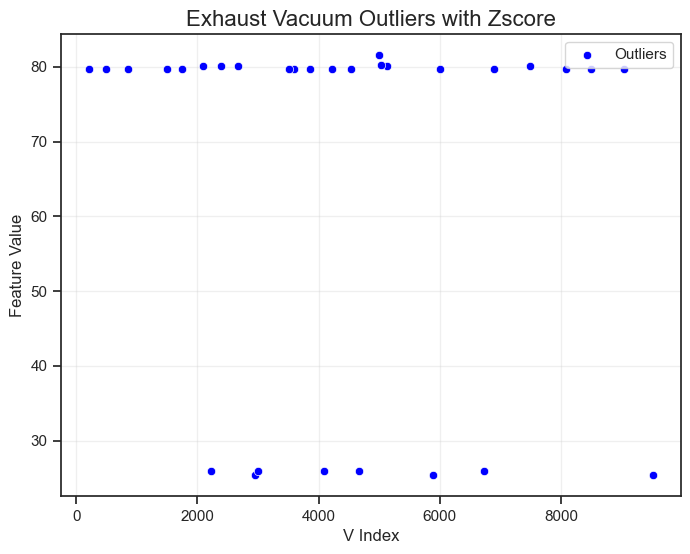

In [275]:
# Calculate Z-scores
z_scores = stats.zscore(X_train_single1)

# Identify outliers (e.g., Z-score > 3 or < -3)
# This is a common threshold for identifying outliers. We want outliers that are 3 or more standard deviations away from the mean.
# In this specific case, changed to 2 STD. because no outliers were detected with 3
outliers = np.abs(z_scores) > 2

# Create scatter plot with outliers highlighted
plt.figure(figsize=(8, 6))
# sns.scatterplot(x=X_train_single.index, y=X_train_single, color='blue', label='Data Points')
sns.scatterplot(x=X_train_single1.index[outliers], y=X_train_single1[outliers], color='blue', label='Outliers')

# Add labels and title
plt.xlabel('V Index', fontsize=12)
plt.ylabel('Feature Value', fontsize=12)
plt.title('Exhaust Vacuum Outliers with Zscore', fontsize=16)

# Show grid and legend
plt.grid(alpha=0.3)
plt.legend()
plt.show()


Cook's Distance: [2.16498591e-04 5.56399738e-04 7.85459066e-05 ... 1.23137183e-04
 9.51931540e-06 6.24264032e-06]


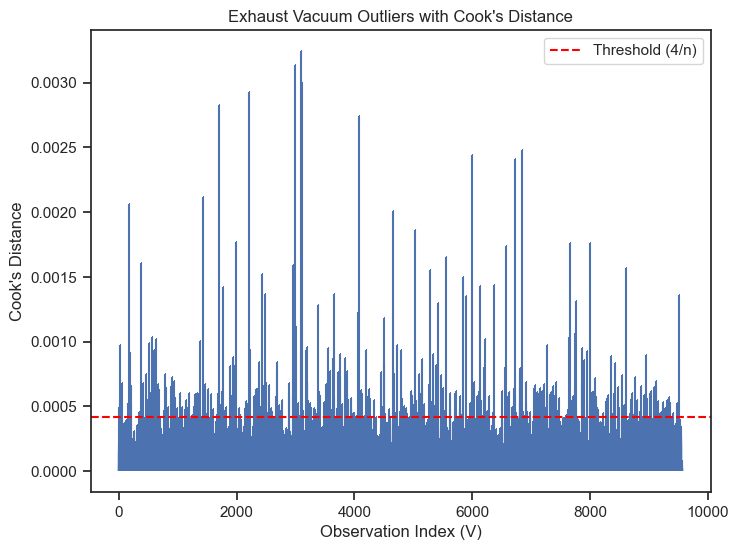

In [258]:
X_feature = sm.add_constant(X[['V']])
model = sm.OLS(y, X_feature).fit()

influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

print("Cook's Distance:", cooks_distance)

# Plot Cook's distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.axhline(4 / len(cooks_d), color='red', linestyle='--', label='Threshold (4/n)')
plt.title("Exhaust Vacuum Outliers with Cook's Distance")
plt.xlabel("Observation Index (V)")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

# Identify influential points
influential_points = np.where(cooks_d > (4 / len(cooks_d)))[0]
# print(f"Influential Points: {influential_points}")

## Ambient Pressure Plot 

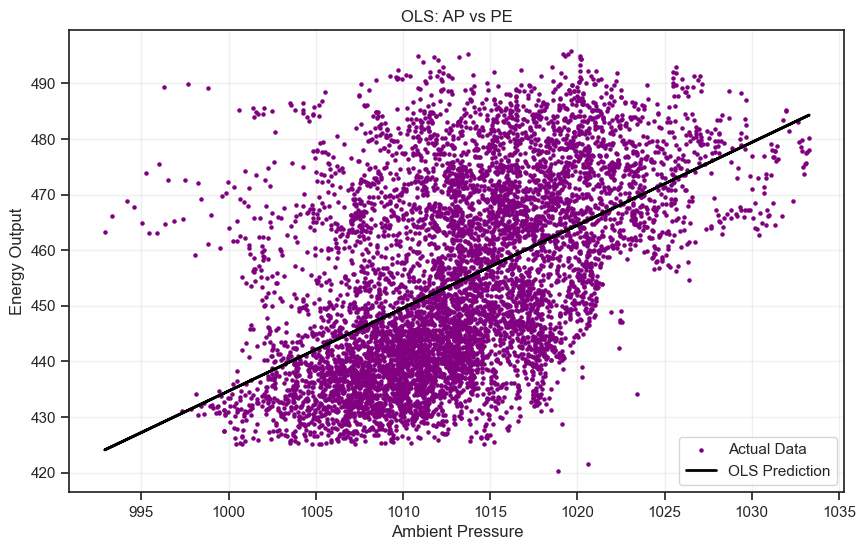

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     2817.
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:14:19   Log-Likelihood:                -31380.
No. Observations:                7654   AIC:                         6.276e+04
Df Residuals:                    7652   BIC:                         6.278e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1055.0686     28.442    -37.095      0.0

In [307]:
# Select one feature from X_train (e.g., the second feature = V)
feature_index = 2  # Change this to 1, 2, or 3 for other features
X_train_single2 = X_train.iloc[:, feature_index]  # Extract the selected feature

# Add a constant term to the feature (required for statsmodels OLS)
X_train_single_const2 = sm.add_constant(X_train_single2)

# Fit a new model using only this feature
model_single = sm.OLS(y_train, X_train_single_const2).fit()

# Extract the coefficient and append it to the list 
model_params = model_single.params[-1]
model_parameters_list.append(model_params.tolist())

# Make predictions using the single-feature model
y_pred_single = model_single.predict(X_train_single_const2)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train_single2, y_train, s=5, color='purple', label='Actual Data')
plt.plot(X_train_single2, y_pred_single, color='black', linewidth=2, label='OLS Prediction')

# Add labels and title
plt.xlabel('Ambient Pressure')
plt.ylabel('Energy Output')
plt.title('OLS: AP vs PE')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print the model summary
print(model_single.summary())
print(model_parameters_list)

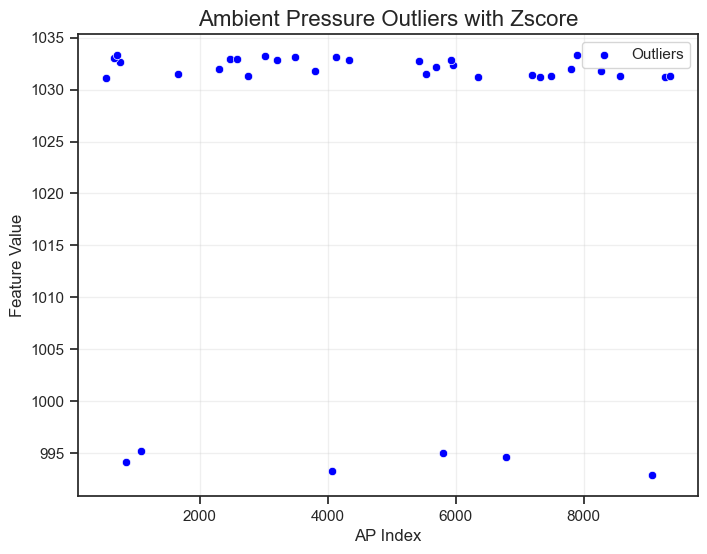

In [273]:
# Calculate Z-scores
z_scores = stats.zscore(X_train_single2)

# Identify outliers (e.g., Z-score > 3 or < -3)
# This is a common threshold for identifying outliers. We want outliers that are 3 or more standard deviations away from the mean.
outliers = np.abs(z_scores) > 3

# Create scatter plot with outliers highlighted
plt.figure(figsize=(8, 6))
# sns.scatterplot(x=X_train_single.index, y=X_train_single, color='blue', label='Data Points')
sns.scatterplot(x=X_train_single2.index[outliers], y=X_train_single2[outliers], color='blue', label='Outliers')

# Add labels and title
plt.xlabel('AP Index', fontsize=12)
plt.ylabel('Feature Value', fontsize=12)
plt.title('Ambient Pressure Outliers with Zscore', fontsize=16)

# Show grid and legend
plt.grid(alpha=0.3)
plt.legend()
plt.show()


Cook's Distance: [2.16498591e-04 5.56399738e-04 7.85459066e-05 ... 1.23137183e-04
 9.51931540e-06 6.24264032e-06]


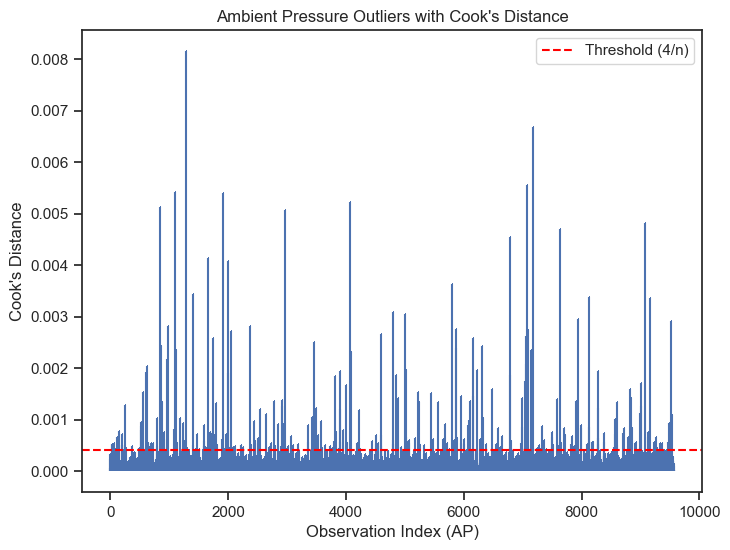

In [265]:
X_feature = sm.add_constant(X[['AP']])
model = sm.OLS(y, X_feature).fit()

influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

print("Cook's Distance:", cooks_distance)

# Plot Cook's distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.axhline(4 / len(cooks_d), color='red', linestyle='--', label='Threshold (4/n)')
plt.title("Ambient Pressure Outliers with Cook's Distance")
plt.xlabel("Observation Index (AP)")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

# Identify influential points
influential_points = np.where(cooks_d > (4 / len(cooks_d)))[0]
# print(f"Influential Points: {influential_points}")

## Relative Humidity Plot

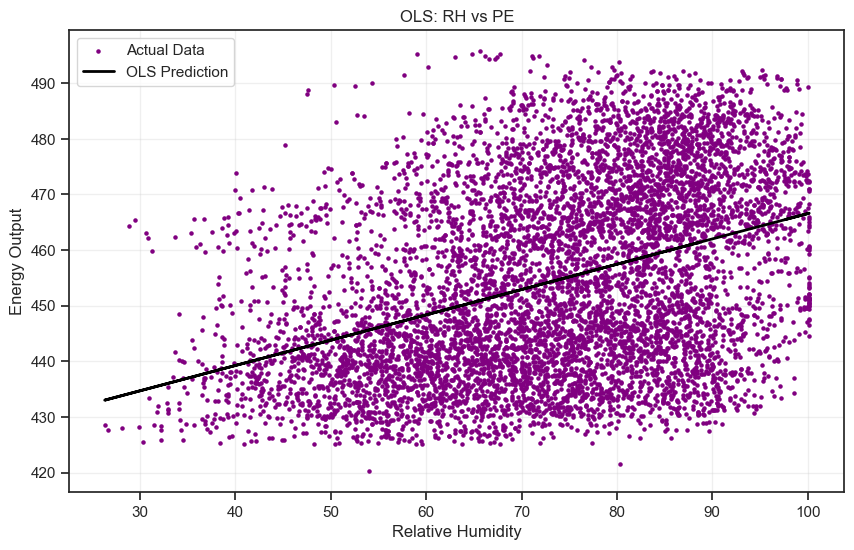

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1371.
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          4.09e-276
Time:                        21:14:40   Log-Likelihood:                -31949.
No. Observations:                7654   AIC:                         6.390e+04
Df Residuals:                    7652   BIC:                         6.392e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        421.0546      0.919    458.008      0.0

In [308]:
# Select one feature from X_train (e.g., the second feature = V)
feature_index = 3  # Change this to 1, 2, or 3 for other features
X_train_single3 = X_train.iloc[:, feature_index]  # Extract the selected feature

# Add a constant term to the feature (required for statsmodels OLS)
X_train_single_const3 = sm.add_constant(X_train_single3)

# Fit a new model using only this feature
model_single = sm.OLS(y_train, X_train_single_const3).fit()

# Extract the coefficient and append it to the list 
model_params = model_single.params[-1]
model_parameters_list.append(model_params.tolist())

# Make predictions using the single-feature model
y_pred_single = model_single.predict(X_train_single_const3)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train_single3, y_train, s=5, color='purple', label='Actual Data')
plt.plot(X_train_single3, y_pred_single, color='black', linewidth=2, label='OLS Prediction')

# Add labels and title
plt.xlabel('Relative Humidity')
plt.ylabel('Energy Output')
plt.title('OLS: RH vs PE')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print the model summary
print(model_single.summary())
print(model_parameters_list)


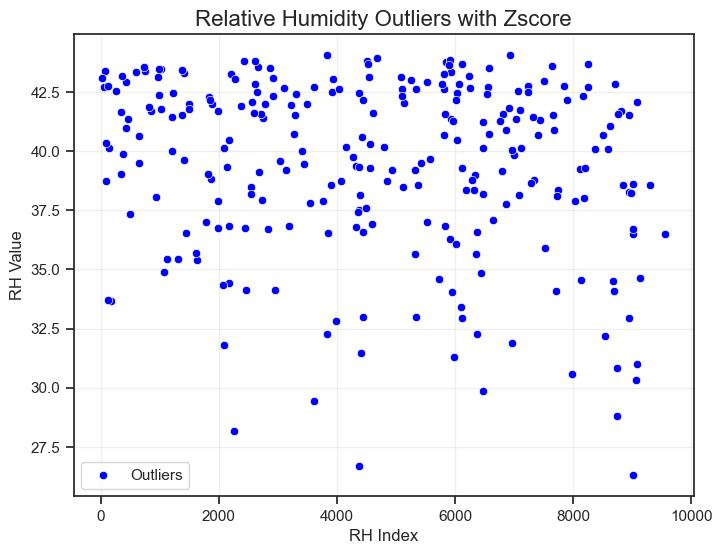

In [272]:
# Calculate Z-scores
z_scores = stats.zscore(X_train_single3)

# Identify outliers (e.g., Z-score > 3 or < -3)
# This is a common threshold for identifying outliers. We want outliers that are 3 or more standard deviations away from the mean.
# In this specific case, changed to 2 STD. because not enough outliers were detected with 3. 
# However, by changing the STD to 2 it could be identifying points that are important to our data and not necessarily outliers. 
outliers = np.abs(z_scores) > 2

# Create scatter plot with outliers highlighted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_single3.index[outliers], y=X_train_single3[outliers], color='blue', label='Outliers')

# Add labels and title
plt.xlabel('RH Index', fontsize=12)
plt.ylabel('RH Value', fontsize=12)
plt.title('Relative Humidity Outliers with Zscore', fontsize=16)

# Show grid and legend
plt.grid(alpha=0.3)
plt.legend()
plt.show()


Cook's Distance: [2.16498591e-04 5.56399738e-04 7.85459066e-05 ... 1.23137183e-04
 9.51931540e-06 6.24264032e-06]


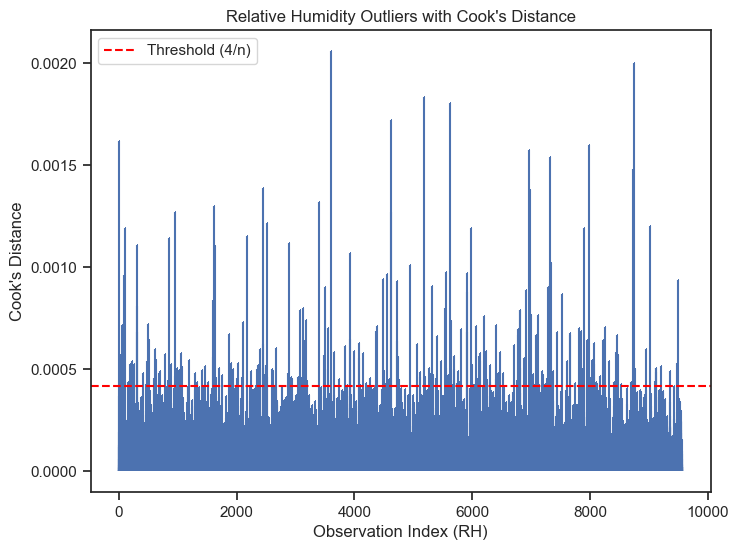

In [268]:
X_feature = sm.add_constant(X[['RH']])
model = sm.OLS(y, X_feature).fit()

influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

print("Cook's Distance:", cooks_distance)

# Plot Cook's distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.axhline(4 / len(cooks_d), color='red', linestyle='--', label='Threshold (4/n)')
plt.title("Relative Humidity Outliers with Cook's Distance")
plt.xlabel("Observation Index (RH)")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

# Identify influential points
influential_points = np.where(cooks_d > (4 / len(cooks_d)))[0]
# print(f"Influential Points: {influential_points}")

### d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 : βj = 0

In [271]:
x_train_sm = sm.add_constant(X_train)

# Fit a multiple regression model 
multi_mod = sm.OLS(y_train, x_train_sm)
multi_res = multi_mod.fit()

# Print out the model's summary 
print(multi_res.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.477e+04
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:30:55   Log-Likelihood:                -22492.
No. Observations:                7654   AIC:                         4.499e+04
Df Residuals:                    7649   BIC:                         4.503e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.5691     10.901     41.700      0.0

In [298]:
# Save the multi regression parameters for later use 
multi_params = multi_res.params[1:]

### Summary: Multi Model Observations 
The model's summary shown above has demonstrated that all of our dataset's predictors (AT, V, AP, RH) have a p-value of 0.000. This means we can reject the null hypothesis because this value is less than 0.05. In addition, our R squared is 0.928 which means 92.8% of the variance in the dependent variable is explained by the independent variables. 

### e) How do your results from 1c compare to your results from 1d? 
### Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the ultiple regression coefficients from 1d on the y-axis. 
- That is, each predictor is displayed as a single point in the plot. 
- The coefficient is a simple linear regression model shown on the x-axis. 
- The coefficient estimate in the multiple linear regression model is shown on the y-axis. 

In [ ]:
params = model_single.params

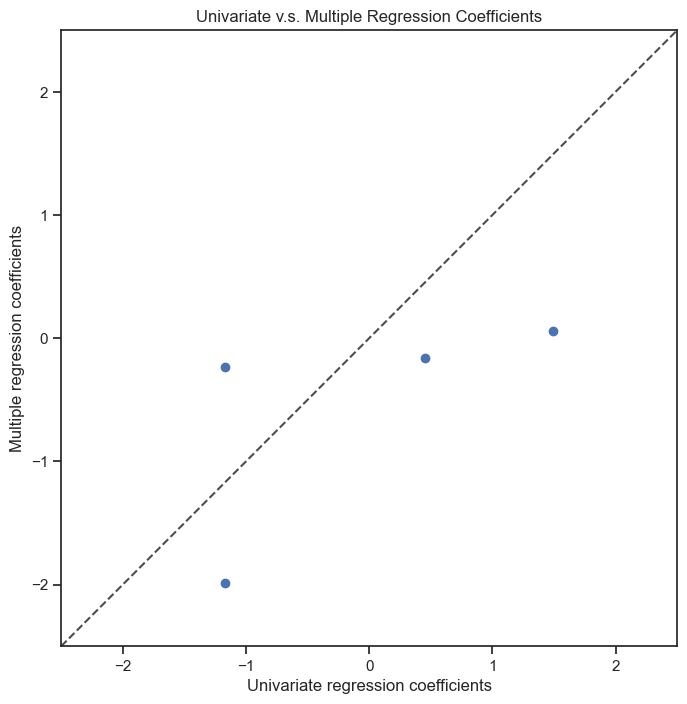

In [311]:
# Add annotation
n = ["AT", "V", "AP", "RH"]

# Plot univariate regression coefficient on x-axis
# Plot multiple regression coefficients on y-axis
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(model_parameters_list, multi_params)

plt.xlabel("Univariate regression coefficients")
plt.ylabel("Multiple regression coefficients")
plt.title("Univariate v.s. Multiple Regression Coefficients")

# Add annotation
for i in range(min(len(n), len(coefficients), len(multi_params))):
    ax.annotate(n[i], (coefficients[i]+0.05, multi_params[i]))

# Fix axis length
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.gca().set_aspect('equal', adjustable='box')

# Draw a diagnal line to assist us
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

In [310]:
print(len(n), len(coefficients), len(multi_params))

4 0 4


### f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this qestin for each predictor X, fit a model of the form 
Y = β0 + β1X = β2X^2 + β3X^3 + error term

#### Ambient Temperature vs. Energy Output

In [319]:
X_train.head()

AT      V       AP     RH
5487  21.92  49.02  1009.29  88.56
3522  11.09  40.43  1025.47  74.97
6916   8.49  39.61  1021.05  87.74
7544  11.43  44.78  1013.43  82.45
7600  17.28  39.99  1007.09  74.25

In [320]:
# Select one feature from X_train (e.g., the second feature = V)
feature_index = 0  # Change this to 1, 2, or 3 for other features
X_train_single0 = X_train.iloc[:, feature_index]  # Extract the selected feature

# Create polynomial features 
degree = 3
X_poly = np.column_stack([X_train_single0**i for i in range(1, degree+1)])

# Add a constant term 
X_poly_const = sm.add_constant(X_poly)

# Fit a new model using only this feature
model_single = sm.OLS(y_train, X_poly_const).fit()

# Extract the coefficient and append it to the list 
model_params = model_single.params[-1]
model_parameters_list.append(model_params.tolist())

# Make predictions using the single-feature model
y_pred_single = model_single.predict(X_poly_const)

# Print the model summary
print(model_single.summary())
print(model_parameters_list)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                 2.627e+04
Date:                Fri, 14 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:49:23   Log-Likelihood:                -23299.
No. Observations:                7654   AIC:                         4.661e+04
Df Residuals:                    7650   BIC:                         4.663e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        493.1219      0.764    645.150      0.0

#### Exhaust Vacuum vs. Energy Output

In [321]:
# Select one feature from X_train (e.g., the second feature = V)
feature_index = 1  # Change this to 1, 2, or 3 for other features
X_train_single1 = X_train.iloc[:, feature_index]  # Extract the selected feature

# Create polynomial features 
degree = 3
X_poly = np.column_stack([X_train_single1**i for i in range(1, degree+1)])

# Add a constant term 
X_poly_const = sm.add_constant(X_poly)

# Fit a new model using only this feature
model_single = sm.OLS(y_train, X_poly_const).fit()

# Extract the coefficient and append it to the list 
model_params = model_single.params[-1]
model_parameters_list.append(model_params.tolist())

# Make predictions using the single-feature model
y_pred_single = model_single.predict(X_poly_const)

# Print the model summary
print(model_single.summary())
print(model_parameters_list)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     8850.
Date:                Fri, 14 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:49:26   Log-Likelihood:                -26848.
No. Observations:                7654   AIC:                         5.370e+04
Df Residuals:                    7650   BIC:                         5.373e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        574.3455     10.623     54.065      0.0

#### Ambient Pressure vs. Energy Output

In [322]:
# Select one feature from X_train (e.g., the second feature = V)
feature_index = 2  # Change this to 1, 2, or 3 for other features
X_train_single2 = X_train.iloc[:, feature_index]  # Extract the selected feature

# Create polynomial features 
degree = 3
X_poly = np.column_stack([X_train_single2**i for i in range(1, degree+1)])

# Add a constant term 
X_poly_const = sm.add_constant(X_poly)

# Fit a new model using only this feature
model_single = sm.OLS(y_train, X_poly_const).fit()

# Extract the coefficient and append it to the list 
model_params = model_single.params[-1]
model_parameters_list.append(model_params.tolist())

# Make predictions using the single-feature model
y_pred_single = model_single.predict(X_poly_const)

# Print the model summary
print(model_single.summary())
print(model_parameters_list)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     1446.
Date:                Fri, 14 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:50:48   Log-Likelihood:                -31352.
No. Observations:                7654   AIC:                         6.271e+04
Df Residuals:                    7651   BIC:                         6.273e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0687      0.010      6.926      0.0

#### Relative Humidity vs. Energy Output

In [323]:
# Select one feature from X_train (e.g., the second feature = V)
feature_index = 3  # Change this to 1, 2, or 3 for other features
X_train_single3 = X_train.iloc[:, feature_index]  # Extract the selected feature

# Create polynomial features 
degree = 3
X_poly = np.column_stack([X_train_single3**i for i in range(1, degree+1)])

# Add a constant term 
X_poly_const = sm.add_constant(X_poly)

# Fit a new model using only this feature
model_single = sm.OLS(y_train, X_poly_const).fit()

# Extract the coefficient and append it to the list 
model_params = model_single.params[-1]
model_parameters_list.append(model_params.tolist())

# Make predictions using the single-feature model
y_pred_single = model_single.predict(X_poly_const)

# Print the model summary
print(model_single.summary())
print(model_parameters_list)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     464.0
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          5.49e-277
Time:                        11:52:01   Log-Likelihood:                -31940.
No. Observations:                7654   AIC:                         6.389e+04
Df Residuals:                    7650   BIC:                         6.391e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        471.7777     11.829     39.882      0.0

### g) Is there evidence of association of interactions of predictors with the response? 
- To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant. 

In [336]:
from sklearn.preprocessing import PolynomialFeatures
# Select all pairwise features from X_train 
X_train_all = X_train

# Create polynomial features with interactions only
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_train_all)

# Add a constant term to the features 
X_interactions_constant = sm.add_constant(X_interactions)

# Fit a new model using all features 
model_all = sm.OLS(y_train, X_interactions_constant).fit()

# Make predictions using the full model 
y_pred_all = model_all.predict(X_interactions_constant)

print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     8157.
Date:                Fri, 14 Feb 2025   Prob (F-statistic):               0.00
Time:                        13:03:17   Log-Likelihood:                -21981.
No. Observations:                7654   AIC:                         4.399e+04
Df Residuals:                    7639   BIC:                         4.410e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1905.4318    381.608      4.993      0.0

In [337]:
feature_names = X_train.columns.tolist()

# Get the feature names including interactions
interaction_features = poly.get_feature_names_out(feature_names)

# Create a DataFrame to see the features clearly
df_interactions = pd.DataFrame(X_interactions, columns=interaction_features)

print(df_interactions.columns)

Index(['AT', 'V', 'AP', 'RH', 'AT V', 'AT AP', 'AT RH', 'V AP', 'V RH',
       'AP RH', 'AT V AP', 'AT V RH', 'AT AP RH', 'V AP RH'],
      dtype='object')


### Summary 
In order to determine which interactions between terms are statistically significant, lets look at the p-value of some coefficients above and the features liste when we extract feature names. 
For interaction term X5 = AT * AP, interaction term X6 = AT * RH, interaction term, and interaction term X8 = V * RH, their corresponding p-values are less than 0.05 which indicates that these interaction terms are statistically significant. 

### h) Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? 
- Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs. 

In [338]:
# Split training and testing data 
# For each predictor, fit a simple linear regression model to predict a response 
X = cpp_data[['AT', 'V', 'AP', 'RH']]
y = cpp_data['PE']
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.7, random_state=42, stratify=None)

# Add constant 
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6697, 4)
X_test shape: (1914, 4)
y_train shape: (6697,)
y_test shape: (1914,)


In [377]:
summarize_test_error = {}
# Train regression model with all predictors
# Fit regression model
regr_mod = sm.OLS(y_train, X_train_sm).fit()

# Make prediction
regr_train_pred = regr_res.predict(X_train_sm)
regr_test_pred = regr_res.predict(X_test_sm)

# Calculate train MSE
regr_train_mse = mean_squared_error(y_train, regr_train_pred)
# Calculate test MSE
regr_test_mse = mean_squared_error(y_test, regr_test_pred)

# Store test MSE
summarize_test_error['Linear Regression without interaction'] = regr_test_mse

In [345]:
# Create polynomial features with interactions only
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
X_train_transform = poly.fit_transform(X_train)

# Fit a new model using all features 
model_all = sm.OLS(y_train, X_train_transform).fit()

# Make predictions using the full model 
y_pred_all = model_all.predict(X_train_transform)

print(model_all.summary())

                                 OLS Regression Results                                
Dep. Variable:                     PE   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.367e+06
Date:                Fri, 14 Feb 2025   Prob (F-statistic):                        0.00
Time:                        16:36:11   Log-Likelihood:                         -19254.
No. Observations:                6697   AIC:                                  3.854e+04
Df Residuals:                    6683   BIC:                                  3.863e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [346]:
feature_names = X_train.columns.tolist()

# Get the feature names including interactions
interaction_features = poly.get_feature_names_out(feature_names)

# Create a DataFrame to see the features clearly
df_interactions = pd.DataFrame(X_interactions, columns=interaction_features)

print(df_interactions.columns)

Index(['AT', 'V', 'AP', 'RH', 'AT V', 'AT AP', 'AT RH', 'V AP', 'V RH',
       'AP RH', 'AT V AP', 'AT V RH', 'AT AP RH', 'V AP RH'],
      dtype='object')


Given the summary of our model, lets remove insignificant variables based on p-values greater than 0.05. 
We want to remove X8 = V * RH becuase its corresponding p value of coefficient is greater than 0.05, which would indicate that they are not statistically significant. 

In [351]:
# Remove variables mentioned above 
X_train_reduce = X_train_transform[:, [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13]]

# Preprocess testing data 
X_test_reduce = poly.fit_transform(X_test)[:, [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13]]

In [380]:
# Train the new model 
# Train regression model with all predictors
# Fit regression model
reduce_res = sm.OLS(y_train, X_train_reduce).fit()

# Make prediction
reduce_train_pred = reduce_res.predict(X_train_reduce)
reduce_test_pred = reduce_res.predict(X_test_reduce)

# Calculate train MSE
reduce_train_mse = mean_squared_error(y_train, reduce_train_pred)
# Calculate test MSE
reduce_test_mse = mean_squared_error(y_test, reduce_test_pred)

# Store test MSE 
summarize_test_error['Linear Regression with interaction'] = reduce_test_mse

In [355]:
# Report MSE for both model
print("Train MSE for model with out interaction is", regr_train_mse)
print("Test MSE for model with out interaction is", regr_test_mse)
print("")
print("Train MSE for model with interaction is", reduce_train_mse)
print("Test MSE for model with interaction is", reduce_test_mse)

Train MSE for model with out interaction is 21.057047227788033
Test MSE for model with out interaction is 20.27997190502141

Train MSE for model with interaction is 18.555317424437362
Test MSE for model with interaction is 18.20007311229081


### Observations 
The model with interaction terms and quadractic nonlinearities is more improved because it has a smaller MSE in training and testing. 


### i) Perform k nearest neighbor for this dataset using both normalized and raw features. Find the value of k within the range of {1,2,... 100} that gives you the best fit. Plot the train and test errors in terms of 1/k. 

In [359]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

# Preprocess normalizing data
scaler = MinMaxScaler()
scaling_model = scaler.fit(X_train)

# Normalize training and testing data
X_train_normalized = scaling_model.transform(X_train)
X_test_normalized = scaling_model.transform(X_test)

In [387]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Initialize k values
k_values = range(1, 101)
k_inverse = [1/k for k in k_values]

train_mse = list()
test_mse = list()

# Function to calculate MSE for a given k
def calculate_mse(k, X_train, Y_train, X_test, Y_test):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_pred = knn.predict(X_train_normalized)
    test_pred = knn.predict(X_test_normalized)
    return mean_squared_error(y_train, train_pred), mean_squared_error(y_test, test_pred)

# Calculate MSE for all k values
results = [calculate_mse(k, X_train_normalized, y_train, X_test_normalized, y_test) for k in k_values]

train_mse, test_mse = zip(*results)

In [388]:
# Find optimal k = k* where we have lowest mse and report the result
print('Minimum train MSE with normalized features:', min(train_mse))
print('Optimal k* for training at k =', k_values[np.argmin(train_mse)])
print('Minimum test MSE with normalized features:', min(test_mse))
print('Optimal k* for testing at k =', k_values[np.argmin(test_mse)])

# Store test MSE 
summarize_test_error['KNN Regression with Normalized Features'] = min(test_mse)

Minimum train MSE with normalized features: 0.0
Optimal k* for training at k = 1
Minimum test MSE with normalized features: 14.315269421223741
Optimal k* for testing at k = 6


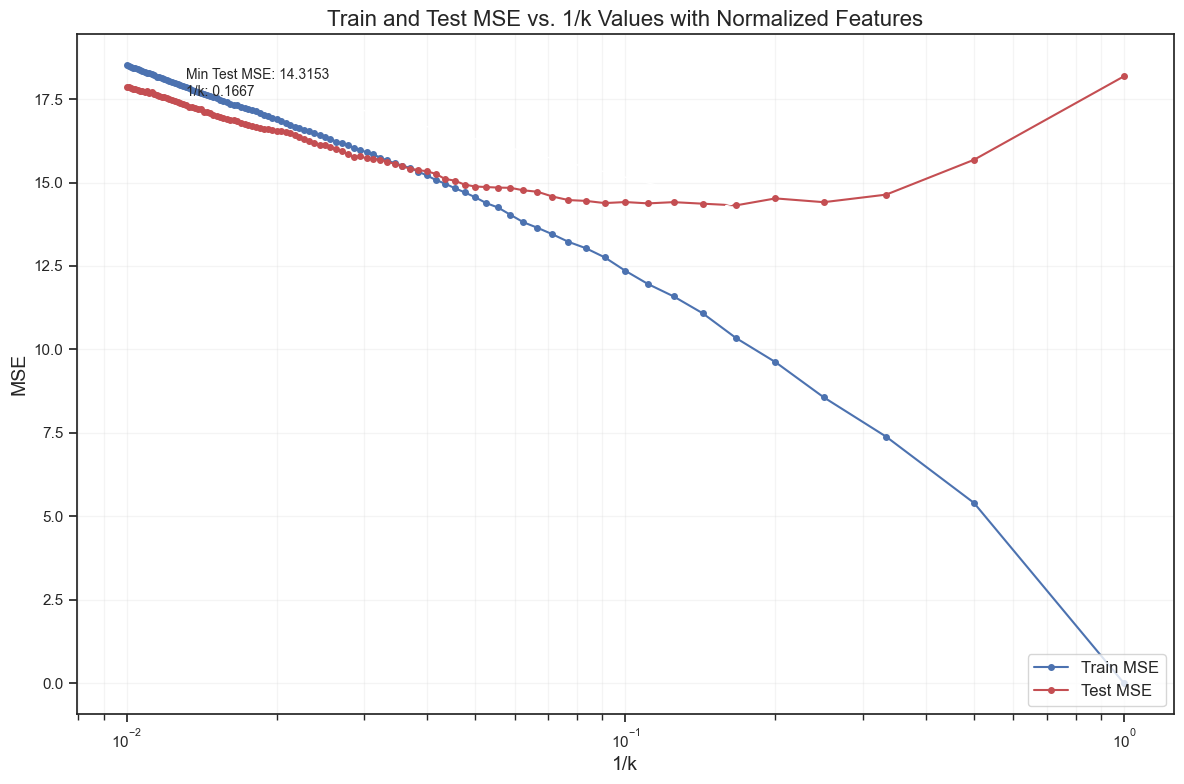

In [367]:
plt.figure(figsize=(12, 8))

# Plot with markers and lines
plt.semilogx(k_inverse, train_mse, 'bo-', label='Train MSE', markersize=4)
plt.semilogx(k_inverse, test_mse, 'ro-', label='Test MSE', markersize=4)

plt.title('Train and Test MSE vs. 1/k Values with Normalized Features', fontsize=16)
plt.xlabel('1/k', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Add grid
plt.grid(True, which="both", ls="-", alpha=0.2)

# Find and annotate minimum test MSE
min_test_mse = min(test_mse)
min_k_inverse = k_inverse[test_mse.index(min_test_mse)]
plt.annotate(f'Min Test MSE: {min_test_mse:.4f}\n1/k: {min_k_inverse:.4f}', 
             xy=(min_k_inverse, min_test_mse), xytext=(0.1, 0.95), 
             textcoords='axes fraction', arrowprops=dict(arrowstyle="->"), 
             fontsize=10, ha='left', va='top')

plt.tight_layout()
plt.show()


In [369]:
# Function to calculate MSE for a given k
def calculate_mse(k, X_train, Y_train, X_test, Y_test):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_raw_pred = knn.predict(X_train)
    test_pred = knn.predict(X_test)
    return mean_squared_error(y_train, train_raw_pred), mean_squared_error(y_test, test_pred)

# Calculate MSE for all k values
results = [calculate_mse(k, X_train_normalized, y_train, X_test_normalized, y_test) for k in k_values]

In [378]:
# Find optimal k = k* where we have lowest mse and report the result
print('Minimum train MSE with raw features:', min(train_mse))
print('Optimal k* for training at k =', k_values[np.argmin(train_mse)])
print('Minimum test MSE with raw features:', min(test_mse))
print('Optimal k* for testing at k =', k_values[np.argmin(test_mse)])

# Store test MSE 
summarize_test_error['KNN Regression with Raw Features'] = min(test_mse)

Minimum train MSE with raw features: 0.0
Optimal k* for training at k = 1
Minimum test MSE with raw features: 14.315269421223741
Optimal k* for testing at k = 6


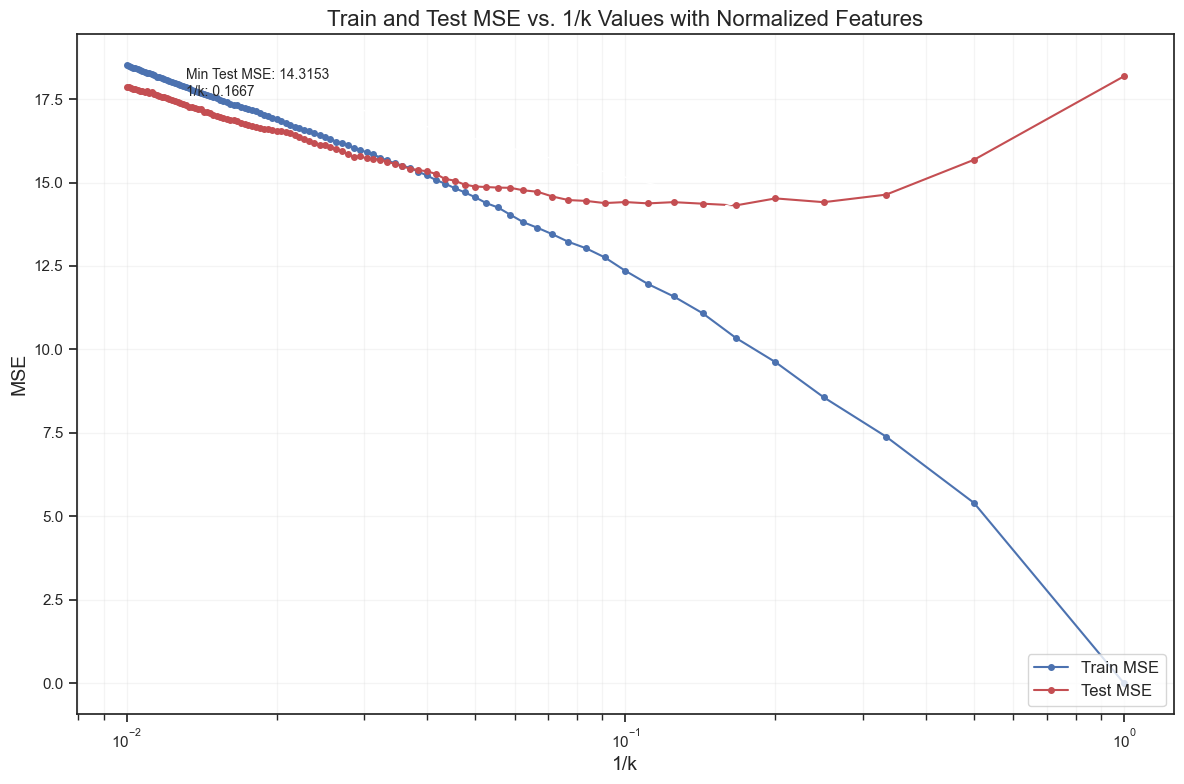

In [371]:
plt.figure(figsize=(12, 8))

# Plot with markers and lines
plt.semilogx(k_inverse, train_mse, 'bo-', label='Train MSE', markersize=4)
plt.semilogx(k_inverse, test_mse, 'ro-', label='Test MSE', markersize=4)

plt.title('Train and Test MSE vs. 1/k Values with Normalized Features', fontsize=16)
plt.xlabel('1/k', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Add grid
plt.grid(True, which="both", ls="-", alpha=0.2)

# Find and annotate minimum test MSE
min_test_mse = min(test_mse)
min_k_inverse = k_inverse[test_mse.index(min_test_mse)]
plt.annotate(f'Min Test MSE: {min_test_mse:.4f}\n1/k: {min_k_inverse:.4f}', 
             xy=(min_k_inverse, min_test_mse), xytext=(0.1, 0.95), 
             textcoords='axes fraction', arrowprops=dict(arrowstyle="->"), 
             fontsize=10, ha='left', va='top')

plt.tight_layout()
plt.show()


Given the k-nearest neighbor regression that used normalized features versus raw features, we can see that the model with normalized features obtained a smaller MSE in the testing state. In addition, we found that at k* = 6, the k nearest neighbor regression with normalized features gave us the best fit with MSE at approximately 14.315.

### j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis. 

In [389]:
# Convert dict into table 
table = pd.DataFrame(summarize_test_error.items(), columns= ['Model Name', 'Test Error'])
display(table)

Model Name  Test Error
0    Linear Regression without interaction   20.279972
1         KNN Regression with Raw Features   14.315269
2  KNN Regression with Normalized Features   14.315269
3       Linear Regression with interaction   18.200073

### Analysis 
From the table above, the KNN Regression with Raw Features and the KNN Regression with Normalized Features have the smalled test error among all models. Overall, the KNN regression models perform better compared to linear regression models. A primary reason this could be is because KNN can capture complex, non-linear patterns in data without assuming a specific functional form, unlike linear regression. In the end, in order to use a linear regression within this dataset it would be beneficial to conduct more rigorous hypothesis testing on the coefficients. 

## 2. ISLR: 2.4.1
### a) The sample size n is extremely large, and the number of predictors p is small. 
We would use a more flexible learning method in this scenario. A more flexible approach would fit the data more closely without overfitting due to the large sample size. 

### b) The number of predictors p is extremely large and the number of observations n is small. 
We would use an inflexible learning method. This is because the small sample size doesn't provide enough information for a flexible model to reliably estimate complex relationships. 

### c) The relationship between the predictors and response is highly non-linear 
We would use a flexible learning method. This is because the relationship is non linear, so we would need a method that can adapt to the learned data. This will better capture the underlying relationship. 

### d) The variance of the error terms is extremely high 
We would use a flexible learning method. High error variance indicates a lot of noise in the data. Flexible models are not likely to fit this noise thus, leading to overfitting. 

## 3 ISLR: 2.4.7

### a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0 
- d1 = $\sqrt{0^2 + 3^2 + 0^2}$ = $\sqrt{9}$ = 3
- d2 = $\sqrt{2^2 + 0^2 + 0^2}$ = $\sqrt{4}$ = 2
- d3 = $\sqrt{0^2 + 0^2 + 3^2}$ = $\sqrt{1 + 9}$ = $\sqrt{10}$
- d4 = $\sqrt{0^2 + 1^2 + 2^2}$ = $\sqrt{1 + 4}$ = $\sqrt{5}$
- d5 = $\sqrt{(-1)^2 + 0^2 + 1^2}$ = $\sqrt{1 + 1}$ = $\sqrt{2}$
- d6 = $\sqrt{1^2 + 1^2 + 1^2}$ = $\sqrt{1^2 + 1^2 + 1^2}$ = $\sqrt{3}$

### b) What is our prediction with K = 1? Why? 
In order to answer this question, we need to look at the closest distance from the test point to make predictions. The test starting point is (0, 0, 0) and combined with our calculations in part a, we find that the predicted point will be $\sqrt{2}$ because this is the closest distance. Our answer will then be Green is the predicted color. 

### c) What is our prediction with K = 3? Why? 
When K = 3, we want to look at the 3 closest points from the test point. Thus, observation 5, observation 6, and observation 4 need to be looked at. Since both observation 4 and 5 are Green and only observation 6 is red, it is safe to assume the predicted color is Green. 

### d) If the Bayes decision boundary in this problem is highly nonlinear, then would we expect the best value for K to be large or small? Why? 
If the Bayes decision boundary in this problem is highly nonlinear we would expect the best value for K to be small. This is because a small K value allows KNN to capture more complex, nonlinear decision boundaries. With a small K, the model can adapt to local patterns and irregularities in the data resulting in a better approximated highly nonlinear Bayes decision boundary. 




### References 
Generating polynomial features: https://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features

Linear Regression Model: https://www.statsmodels.org/stable/regression.html

Preprocessing for Min/Max Scaler: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

Understanding Scoring Functions: https://scikit-learn.org/stable/modules/model_evaluation.html

Understanding Cook's Outlier: 
- https://towardsdatascience.com/identifying-outliers-in-linear-regression-cooks-distance-9e212e9136a/

- https://www.scikit-yb.org/en/latest/api/regressor/influence.html

